In [1]:
import nibabel as nib
nib.imageglobals.logger.setLevel(40)

import numpy as np
import pickle as pk
import scipy.stats

from tqdm.auto import tqdm
from IPython.display import clear_output

from matplotlib import pyplot as plt
from lib.plotting import plot_29k

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Prepare resting state predictors

In [2]:
from sklearn.decomposition import PCA
from brainspace.gradient.alignment import ProcrustesAlignment

from lib.utils import load_hcp_ts_data

from lib.default_config import task_names, tmsmall, smooth_lv, tmap_type, full_subj_path 
from lib.default_config import rest_file_stub as rs_file_stub
from lib.default_config import rest_sessions as sessions
from lib.utils import get_machine_stats

print("Task names:\t\t", ", ".join([t.lower() for t in task_names]))
print("Sessions:\t\t", sessions)
print("RS-File template:\t", rs_file_stub)

all_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
print(f"Subjects (n={len(all_subjs)}):\t", list(all_subjs[:10]), "\n")

get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)

local_dir = "/scratch/users/robert.scholz2/"
bma_slice = slice(29696, 59412, None) # right hemisphere

Task names:		 wm 19 body-avg, wm 20 face-avg, wm 21 place-avg, wm 22 tool-avg, gambling 6 reward-punish, motor 21 avg-cue, language 4 story-math, social 6 tom-random, relational 4 rel-match, emotion 3 faces-shapes
Sessions:		 ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR', 'rfMRI_REST2_RL']
RS-File template:	 HCP_1200/{subj}/MNINonLinear/Results/{session}/{session}_Atlas_MSMAll_hp2000_clean.dtseries.nii
Subjects (n=254):	 ['100206', '100610', '101006', '101309', '101915', '102311', '102513', '106016', '107321', '107422'] 

cpu: 7.4%  vmem: 6.3%  vmem_tot: 376.31gb  n_cpus: 96  pid: 500329  proc_mem: 0.23gb  proc_mem/tot: 0.06%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [9, 10, 11, 33, 34, 35, 57, 58, 59, 81, 82, 83]  assigned_cpu_util_%: [0.  0.  0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.1 0.1]


## Prepare the group reference

In [3]:
!ls {local_dir}HCP_Resources/GroupAvg/

HCP_PTN1200
HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.L29k.dconn.nii.npy
HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii


In [4]:
get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)


cpu: 13.1%  vmem: 6.3%  vmem_tot: 376.31gb  n_cpus: 96  pid: 500329  proc_mem: 0.23gb  proc_mem/tot: 0.06%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [9, 10, 11, 33, 34, 35, 57, 58, 59, 81, 82, 83]  assigned_cpu_util_%: [ 0.   4.2  0.   0.   4.2  4.3  0.  25.   0.   0.  15.4  4.2]


In [77]:
# First prepare the group level reference

# load the full brain connectivity marix (given as fisher z values)
file =r"HCP_Resources/GroupAvg/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii"
#!python -m awscli s3 cp s3://hcp-openaccess/{file} {local_dir}{file}
conmat = nib.load(f"{local_dir}{file}")
cmat_z_full = conmat.get_fdata();

# Reduce to the right hemisphere
cmat_z =cmat_z_full[bma_slice,bma_slice].astype(np.float32)
print(cmat_z.shape)
del cmat_z_full

# Save this matrix to a separate file
file2 =r"HCP_Resources/GroupAvg/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.R29k.dconn.npy"
#np.save(f"{local_dir}{file2}", cmat_z)
!ls -ash {local_dir}{file2}

(29716, 29716)
ls: cannot access '/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.R29k.dconn.npy': No such file or directory


In [78]:
# inverse fisher-z transform the cmat
inv_fis_z = lambda z: (np.exp(2*z)-1)/(np.exp(2*z)+1)
cmat= inv_fis_z(cmat_z)

In [79]:
# decompose this group connectivtiy matrix using PCA

pca1 = PCA(n_components=200)
pca1.fit(cmat) #pca1.fit(ca(cmat))
pcat = lambda x: pca1.transform(x); #pcat = lambda x: pca1.transform(ca(x));
#sklearn.decomposition.IncrementalPCA¶
group_comps = pcat(cmat)
print("Resulting components:", group_comps.shape)

# Save components and weights
np.save("data/group_components.pca200c.R.npy", group_comps)
pk.dump(pca1, open("data/group_conmat_pca.200c.R.pkl","wb"))
!ls -ash data/group_components.pca200c.R.npy
!ls -ash data/group_conmat_pca.200c.R.pkl

Resulting components: (29716, 200)
23M data/group_components.pca200c.R.npy
23M data/group_conmat_pca.200c.R.pkl


In [80]:
del cmat_z
del cmat

## Prepare the aligned individual gradients

In [84]:
all_grads_idvpro = {}
expl_vars_indv = np.zeros((len(full_subjs), 200))
indv_pcas =[]

In [11]:
# loading of existent (to resume processing)
"""p = np.load("/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.pca_info.npy", allow_pickle=1).item()
indv_pcas = p["pca_indvs"]
expl_vars_indv = p["var_expl_ratios"]

fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.npy"
all_grads_idvpro = np.load(fn, allow_pickle=1).item()

#print(list(all_grads_idvpro.keys())[:-10], p["subjs"][:-10])
len(all_grads_idvpro.keys()), len(p["subjs"])""";

(141, 141)

In [12]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
#pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
#pca_zgr = pk.load(open("data/group_conmat_z_pca.200c.pkl",'rb')) 
#pca_gr = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
group_comps = np.load("data/group_components.pca200c.R.npy")

n_comps = 200

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)


for i, subj in tqdm(enumerate(full_subjs), total=len(full_subjs)):
  print(subj)
  if subj in all_grads_idvpro.keys(): continue;

  lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+\
    rs_file_stub, subj, session, zscore=True, bma_slice= slice(29696, 59412, None)) for session in sessions], axis=0)

  icmat = np.corrcoef(lh_full_ts.T)
  
  pca_indv = PCA(n_components=n_comps)
  indiv_comps = pca_indv.fit_transform(icmat)
  indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
  #icomps_zgr = pca_zgr.transform(fishers_z(icmat*0.999999999))
  #icomps_gr = pca_gr.transform(icmat)
  
  expl_vars_indv[i,:] = pca_indv.explained_variance_ratio_
  print(subj, pca_indv.explained_variance_ratio_.sum().round(3))
  indv_pcas.append(pca_indv)
  

  #icomps = scipy.stats.zscore(icomps, axis=0)
  #all_grads_zgr[subj] = icomps_zgr.astype(np.float32);
  #all_grads_gr[subj] = icomps_gr.astype(np.float32);
  all_grads_idvpro[subj] = indiv_comps_aligned.astype(np.float32);
  clear_output(wait=True)  
    
  if i % 10==0:
    fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.npy"
    np.save(fn, all_grads_idvpro)
    np.save("/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.pca_info.npy", \
          {"pca_indvs": indv_pcas, "var_expl_ratios" : expl_vars_indv, "subjs":full_subjs[:i+1]});

100%|██████████| 254/254 [2:23:46<00:00, 33.96s/it]


In [13]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.npy"
np.save(fn, all_grads_idvpro)
np.save("/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.pca_info.npy", {"pca_indvs": indv_pcas, "var_expl_ratios" : expl_vars_indv, "subjs":full_subjs[:i+1]});

In [60]:
unique_contrasts

NameError: name 'unique_contrasts' is not defined

# Collect prediction targets (task contrasts)

In [61]:
from lib.default_config import  contrast_info

paradigms = np.unique([c[0] for c in contrast_info]).tolist()
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str)
print("Tasks:", paradigms)
print("Contrasts:", len(unique_contrasts), list(unique_contrasts[:14]))

Tasks: ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
Contrasts: 47 ['EMOTION_FACES', 'EMOTION_SHAPES', 'EMOTION_FACES-SHAPES', 'GAMBLING_PUNISH', 'GAMBLING_REWARD', 'GAMBLING_REWARD-PUNISH', 'LANGUAGE_MATH', 'LANGUAGE_STORY', 'LANGUAGE_STORY-MATH', 'MOTOR_CUE', 'MOTOR_LF', 'MOTOR_LH', 'MOTOR_RF', 'MOTOR_RH']


In [4]:
def load_subj_full_task_data(subj, contrast_ids, paradigms, dtype=np.float32, v=False, ret_keys=False, \
                            local_dir = "/scratch/users/robert.scholz2/", bma_slice=slice(0, 29696)):
  data = {}
  for para in paradigms: 
    if v: print(para, end=" ")
    fn = local_dir + f"HCP_1200/{subj}/MNINonLinear/Results/tfMRI_{para}/tfMRI_{para}_hp200_s2_level2_MSMAll.feat/{subj}_tfMRI_{para}_level2_hp200_s2_MSMAll.dscalar.nii"
    cifti = nib.load(fn)
    cnames = cifti.header.get_axis(0).name;
    darr = cifti.get_fdata()[:,bma_slice];
    data.update( {name : darr[i] for i, name in enumerate(cnames)})
    #mask = [contains_any(name, contrast_ids) for name in cnames]
    #cifti.get_fdata()[mask,slice(0, 29696)].shape
  
  if v: print(len(data.keys()))    
  dkeys = list(data.keys())
  #tdata = np.array([data[ [x for x in data.keys() if x.startswith(subj+"_"+cid)][0] ] for cid in contrast_ids])
  tdata = []
  contained=[]
  if isinstance(contrast_ids, str) and contrast_ids == "all":
    for key in dkeys:
      if v: print(subj+"_"+cid[:-1], "\t", keys[0])
      tdata.append(data[key])
      contained.append(key)
  else:
    for cid in contrast_ids:
      if v: print(subj+"_tfMRI_"+cid)
      keys = [x for x in dkeys if x.replace("_level2", "").startswith(subj+"_tfMRI_"+cid)]
      tdata.append(data[keys[0]])
      contained.append(keys[0])
  if ret_keys: return np.array(tdata).T.astype(dtype), contained;
  return np.array(tdata).T.astype(dtype);


In [69]:
# loading of a sample subject
data, subj0_task_names = load_subj_full_task_data(all_subjs[0], unique_contrasts, paradigms, bma_slice=bma_slice, ret_keys=1, v=0)
print(data.shape, len(subj0_task_names), list(subj0_task_names[:10]))

(29716, 47) 47 ['100206_tfMRI_EMOTION_level2_FACES_hp200_s2_MSMAll', '100206_tfMRI_EMOTION_level2_SHAPES_hp200_s2_MSMAll', '100206_tfMRI_EMOTION_level2_FACES-SHAPES_hp200_s2_MSMAll', '100206_tfMRI_GAMBLING_level2_PUNISH_hp200_s2_MSMAll', '100206_tfMRI_GAMBLING_level2_REWARD_hp200_s2_MSMAll', '100206_tfMRI_GAMBLING_level2_REWARD-PUNISH_hp200_s2_MSMAll', '100206_tfMRI_LANGUAGE_level2_MATH_hp200_s2_MSMAll', '100206_tfMRI_LANGUAGE_level2_STORY_hp200_s2_MSMAll', '100206_tfMRI_LANGUAGE_level2_STORY-MATH_hp200_s2_MSMAll', '100206_tfMRI_MOTOR_level2_CUE_hp200_s2_MSMAll']


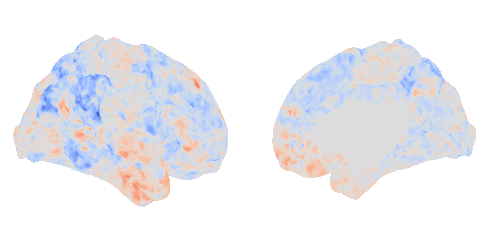

In [59]:
import hcp_utils as hcp
surfs = {"img1": '/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/brainspace/datasets/surfaces/conte69_32k_rh.gii'}
transforms = {"img1": hcp.right_cortex_data}
# plot the language contrast on the right hemisphere
plot_29k(data[:, 8], colorbar=False, plot_conf=["img1_0_0_6.4", "img1_0_180_6.4"], transform = transforms, surfs=surfs)

In [70]:
# accumulate all subjects
data = {subj: load_subj_full_task_data(subj, unique_contrasts, paradigms, bma_slice=bma_slice, v=0) for subj in tqdm(all_subjs)}
print("Number of subjects, and shape per subject:", len(data.keys()), data["100206"].shape)

100%|██████████| 254/254 [16:41<00:00,  3.94s/it]

Number of subjects, and shape per subject: 254 (29716, 47)


In [72]:
import os
fn = "/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.R.raw.npy"#
if not(os.path.exists(fn)): np.save(fn, data);

In [73]:
!ls -ash {fn}

1.4G /scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.R.raw.npy


In [74]:
get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)

cpu: 7.7%  vmem: 6.2%  vmem_tot: 376.31gb  n_cpus: 96  pid: 446329  proc_mem: 1.79gb  proc_mem/tot: 0.48%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [0, 1, 2, 24, 25, 26, 48, 49, 50, 72, 73, 74]  assigned_cpu_util_%: [ 0.6  0.8  0.5  8.4 11.7  7.8  0.1  0.2  0.2  0.6  0.8  0.6]


# model fit

In [7]:
import sys
sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")
from sklearn.utils import Bunch

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.ridge import RidgeCV
from lib.linear_models import predict_y_from_x, score

# helper functions for data loading and predictions
from lib.data_loading import load_xy_data, gather_modalities
from lib.linear_models import predict_y_from_x, predict_from_modality_file, approximate_best_alphas, score

In [11]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.R.raw.npy"
yfull_task_data =np.load(fn, allow_pickle=True).item()
len(yfull_task_data), yfull_task_data['100206'].shape

(254, (29716, 47))

In [12]:
pred_files = {"RS-PCA200" : "all_grads_254_full_unrelated2.R.corrcoef.procrAlignGr.npy" }

In [13]:
cache= {}
regr_data= {}

subjs= all_subjs;
data_dir = "/scratch/users/robert.scholz2/acc_dists/"


z_score_predictors_along_dim = 1# 1 ~ along spatial axis; 0~ across subjects
add_info= "" # could be i.e 
lmodel = "linear" #"ridge"

In [14]:
for combination in [["RS-PCA200"]]: 
  comb_name = " + ".join(combination) + add_info;
  print("____" * 20 + "\nModalities:", comb_name)
  if comb_name in regr_data.keys(): continue; 
  #isubjs, y_train, y_train_pred, y_test, y_test_pred, skr = pred_combined(combination, pred_files, modality_cache=cache)
  comb_predictors = gather_modalities(subjs, combination, pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
  
  #isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yresid_task_data)
  isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
  if not(z_score_predictors_along_dim is None):
    print("z-scoring predictors along d=", z_score_predictors_along_dim)
    xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)
  
  #x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=False)
  y_train, y_train_pred, y_test, y_test_pred, skr = predict_y_from_x(xdata, ydata, lmodel=lmodel, verbose=1)
  scoresd, diff_scores_test = score(y_test_pred, y_test);
  
  regr_data[comb_name] = Bunch(scoresd=scoresd, diff_scores_test=diff_scores_test, isubjs=isubjs, \
     y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_test_pred=y_test_pred, skr=skr)
  
  print("Correlation:", scoresd.corr.mean(0).round(3))
  print("Differentiability:", diff_scores_test.round(3))

________________________________________________________________________________
Modalities: RS-PCA200


Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 116.29it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29716, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29716, 200) (203, 29716, 47) (51, 29716, 200) (51, 29716, 47)
(6032348, 200) (6032348, 47)
Correlation: [0.55  0.542 0.455 0.61  0.635 0.119 0.404 0.44  0.694 0.55  0.444 0.452
 0.405 0.376 0.441 0.461 0.534 0.362 0.422 0.254 0.274 0.412 0.67  0.695
 0.317 0.661 0.696 0.45  0.594 0.564 0.607 0.568 0.509 0.48  0.596 0.56
 0.594 0.509 0.5   0.602 0.576 0.643 0.618 0.287 0.37  0.368 0.206]
Differentiability: [0.118 0.11  0.124 0.16  0.162 0.037 0.145 0.149 0.21  0.157 0.106 0.081
 0.113 0.111 0.09  0.126 0.149 0.051 0.049 0.033 0.038 0.05  0.144 0.147
 0.074 0.162 0.178 0.138 0.15  0.157 0.147 0.146 0.117 0.12  0.125 0.124
 0.15  0.117 0.147 0.145 0.155 0.146 0.147 0.073 0.079 0.092 0.032]


In [15]:
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.extended.npy"
#np.save(fn, regr_data)
!ls -ash {fn}

2.8G results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.extended.npy


In [17]:
keep = ["scoresd", "diff_scores_test", "isubjs", "skr"]
sm_regr_data = {k: {i: v[i] for i in keep} for k,v in regr_data.items()}
#fn = "results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.extended.npy"
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.npy"
np.save(fn, sm_regr_data)
!ls -ash {fn}

100K results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.npy


# Results

In [18]:
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.R.aa.npy"
regr_data = np.load(fn, allow_pickle=1).item()

cdict = {k: v["scoresd"] for k,v in regr_data.items()}
ddict = {k: v["diff_scores_test"] for k,v in regr_data.items()}

In [19]:
print(regr_data.keys(), regr_data['RS-PCA200'].keys())

model = regr_data['RS-PCA200']["skr"]
model.coef_.shape

dict_keys(['RS-PCA200']) dict_keys(['scoresd', 'diff_scores_test', 'isubjs', 'skr'])


(47, 200)

In [36]:
keys = ['RS-PCA200'] #, 'RS-ICA200', 'FS-StructuralMaps', 'SC Blueprints', 'Distance to Parcels (raw)', 'Distance-PCAgra', 'SEmodes',  ]
task_names = ["Language", "Motor", "Emotion", "WM", "Social", "Relational", "Gambling"]
contrast_ids_to_show = [8, 16, 2, 38, 27, 24, 5]


## Overall Scores

In [47]:
import pandas as pd
data = np.array([cdict[k].corr.mean(0)[contrast_ids_to_show].round(3) for k in keys])
print("---- Accuracy (Correlation) ----",data.shape)
print(pd.DataFrame(data, index=keys[:data.shape[0]], columns=task_names))
data = np.array([ddict[k][contrast_ids_to_show].round(3) for k in keys])
print("\n---- Discrimanability ----",data.shape)
print(pd.DataFrame(data, index=keys[:data.shape[0]], columns=task_names))

---- Accuracy (Correlation) ---- (1, 7)
           Language  Motor  Emotion   WM  Social  Relational  Gambling
RS-PCA200     0.694  0.534    0.455  0.5    0.45       0.317     0.119

---- Discrimanability ---- (1, 7)
           Language  Motor  Emotion     WM  Social  Relational  Gambling
RS-PCA200      0.21  0.149    0.124  0.147   0.138       0.074     0.037


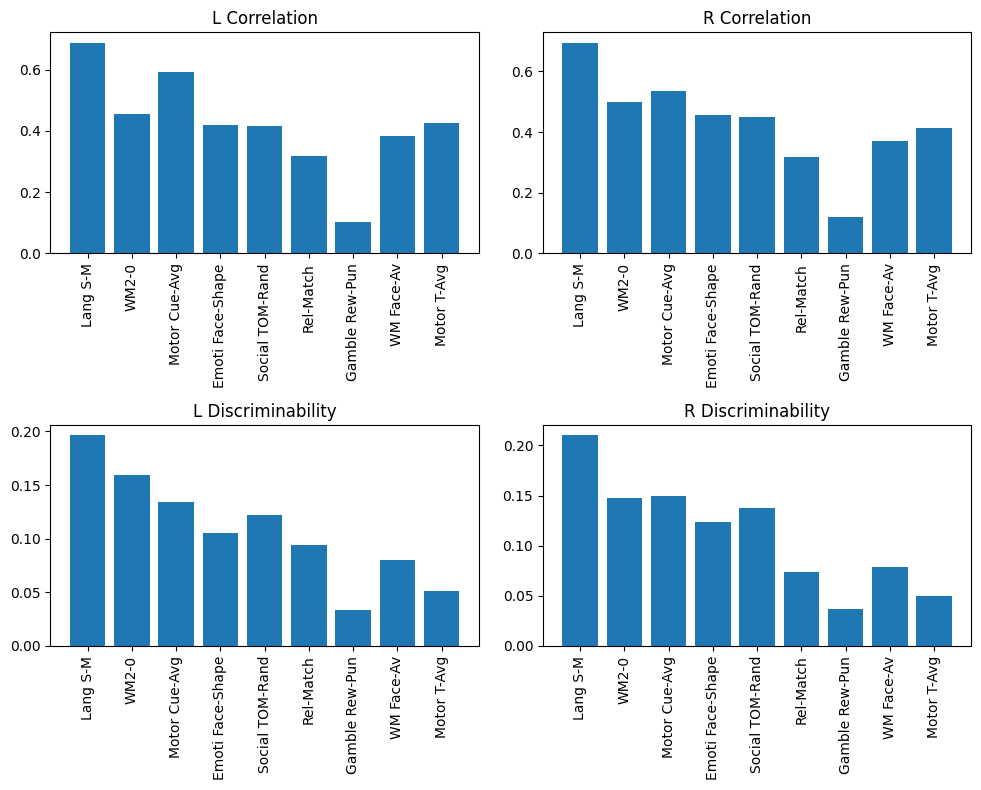

In [92]:
corr_R = scoresd.corr.mean(0)[contrast_ids_to_show];
diff_R = diff_scores_test[contrast_ids_to_show];

corr_L = regr_data_L[modality]["scoresd"]["corr"].mean(0)[contrast_ids_to_show]
diff_L =  regr_data_L[modality]["diff_scores_test"][contrast_ids_to_show];


fig, axs = plt.subplots(2,2, figsize=(10,3*2+2))
axs = np.array(axs).flatten()
titles=["L Correlation", "R Correlation", "L Discriminability", "R Discriminability"]
for i,data in enumerate([corr_L, corr_R, diff_L, diff_R]):
  axs[i].bar(np.arange(len(contrast_ids_to_show)), data)
  axs[i].set_xticks(np.arange(len(tnames_mid)));
  axs[i].set_xticklabels( tnames_mid, rotation=90);
  axs[i].set_title(titles[i])
plt.tight_layout()

## Weights

In [48]:
import cmasher as cmr
cmap_coeffs = "cmr.prinsenvlag_r" #cmc.vik #"PiYG"

In [53]:
modality='RS-PCA200'
coeffs_R = regr_data[modality]["skr"].coef_ # shape (10, 224)

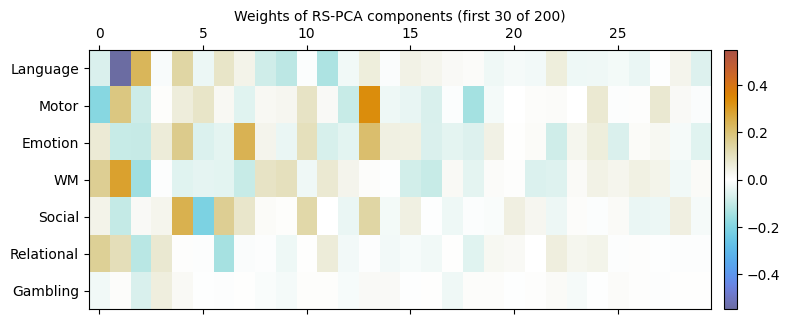

In [58]:
n_comps = 30;

fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];
data = coeffs_R[contrast_ids_to_show,:n_comps]
v = np.absolute(data).max()

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(task_names))); axs[0].set_yticklabels( task_names);
axs[0].set_xlabel(f"Weights of RS-PCA components (first {n_comps} of 200)"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()

In [62]:
idxs = np.argsort(np.abs(coeffs_R), axis=1)
for n in range(len(task_names)):
  tn = contrast_ids_to_show[n]
  txt = f"ten biggest coeffs for {unique_contrasts[tn]} ";
  print(txt, (44-len(txt))*" ", "at components:\t", idxs[tn][::-1][:10])

ten biggest coeffs for LANGUAGE_STORY-MATH    at components:	 [ 1  2  4 11  9  6  8  0 29 22]
ten biggest coeffs for MOTOR_CUE-AVG          at components:	 [13  0  1 18 12 10  5  2 30 27]
ten biggest coeffs for EMOTION_FACES-SHAPES   at components:	 [ 7 13  4 10  2  1 22  0 11 25]
ten biggest coeffs for WM_2BK-0BK             at components:	 [ 1  0  2  9 16  7  8 15 11 21]
ten biggest coeffs for SOCIAL_TOM-RANDOM      at components:	 [ 4  5  6 13 10  1  7 28 20 15]
ten biggest coeffs for RELATIONAL_REL-MATCH   at components:	 [ 0  6  2  1  3 11 22 18 24 23]
ten biggest coeffs for GAMBLING_REWARD-PUNISH   at components:	 [ 2  3 17  0  4  9 14 13 23 12]


In [68]:
idxs = np.argsort(np.abs(coeffs_R), axis=1)
for n in range(len(task_names)):
  txt = f"ten biggest coeffs for {task_names[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (35-len(txt))*" ", "at components:\t", end="")
  for c in idxs[tn][::-1][:5]:
     print(f"c{c}", coeffs_R[tn, c].round(3), end=" | ")
  print("")

ten biggest coeffs for Language      at components:	c1 -0.55 | c2 0.235 | c4 0.137 | c11 -0.133 | c9 -0.112 | 
ten biggest coeffs for Motor         at components:	c13 0.333 | c0 -0.191 | c1 0.186 | c18 -0.145 | c12 -0.094 | 
ten biggest coeffs for Emotion       at components:	c7 0.244 | c13 0.211 | c4 0.17 | c10 0.105 | c2 -0.097 | 
ten biggest coeffs for WM            at components:	c1 0.288 | c0 0.161 | c2 -0.153 | c9 0.102 | c16 -0.095 | 
ten biggest coeffs for Social        at components:	c4 0.248 | c5 -0.211 | c6 0.161 | c13 0.137 | c10 0.132 | 
ten biggest coeffs for Relational    at components:	c0 0.157 | c6 -0.144 | c2 -0.116 | c1 0.109 | c3 0.076 | 
ten biggest coeffs for Gambling      at components:	c2 -0.066 | c3 0.056 | c17 -0.027 | c0 -0.026 | c4 0.02 | 


**compare with left hemisphere component weights**

In [69]:
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy"
regr_data_L = np.load(fn, allow_pickle=1).item();
print(regr_data_L.keys())
coeffs_L = regr_data_L[modality]["skr"].coef_ # shape (10, 224)

dict_keys(['RS-PCA200', 'FS-StructuralMaps'])


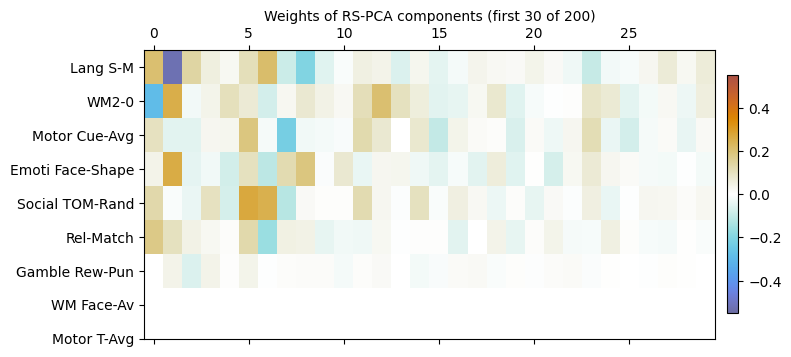

In [70]:
fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];
data = coeffs_L[contrast_ids_to_show,:n_comps]
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xlabel(f"Weights of RS-PCA components (first {n_comps} of 200)"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()

**alignment**

In [83]:
coeffs_L.shape

(47, 200)

In [84]:
coeffs_R = regr_data[modality]["skr"].coef_ # shape (10, 224)
coeffs_L = regr_data_L[modality]["skr"].coef_ # shape (10, 224)

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)

coeffs_R_aligned2L = alignment.fit([coeffs_R], coeffs_L).aligned_[0]

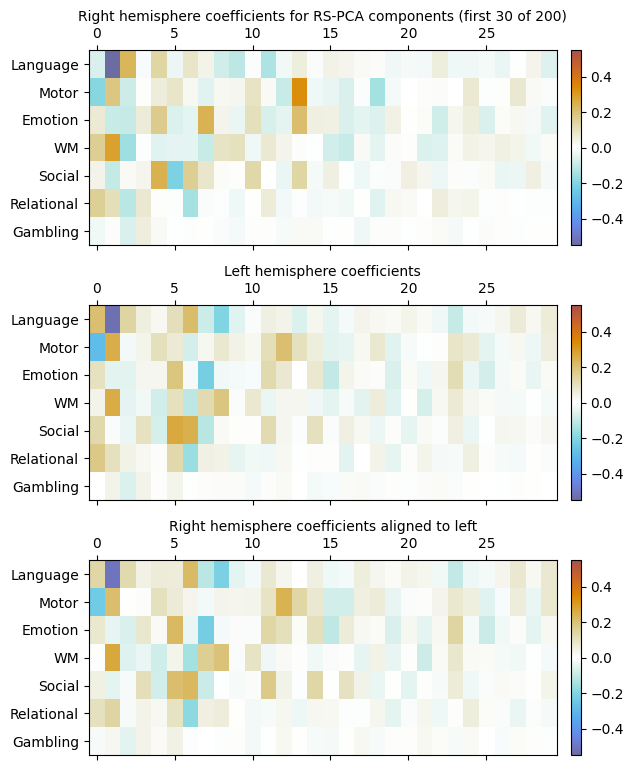

In [93]:
fig, axs = plt.subplots(3,1, figsize=(8,3.9*2)) # 4 plots in a row
data0 = coeffs_R[contrast_ids_to_show,:n_comps]
data1 = coeffs_L[contrast_ids_to_show,:n_comps]
data2 = coeffs_R_aligned2L[contrast_ids_to_show,:n_comps]

v = np.absolute(np.concatenate((data0, data1,data2))).max()

titles=[f"Right hemisphere coefficients for RS-PCA components (first {n_comps} of 200)", \
        f"Left hemisphere coefficients", "Right hemisphere coefficients aligned to left"];
for i, data in enumerate([data0, data1, data2]):
    im = axs[i].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
    plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[i])
    axs[i].set_yticks(np.arange(len(task_names))); axs[i].set_yticklabels( task_names);
    axs[i].set_xlabel(titles[i]); axs[i].xaxis.set_label_position('top') 
    plt.tight_layout()

In [78]:
idxs = np.argsort(np.abs(coeffs_R_aligned2L), axis=1)
for n in range(len(task_names)):
  tn = contrast_ids_to_show[n]
  txt = f"ten biggest coeffs for {unique_contrasts[tn]} ";
  print(txt, (44-len(txt))*" ", "at components:\t", idxs[tn][::-1][:10])

ten biggest coeffs for LANGUAGE_STORY-MATH    at components:	 [ 1  6  8  0  2  7 23 29 27 11]
ten biggest coeffs for MOTOR_CUE-AVG          at components:	 [12  0  1 13  4 11 16 15 23 29]
ten biggest coeffs for EMOTION_FACES-SHAPES   at components:	 [ 7  5 23 11 15 12 14 25  3  0]
ten biggest coeffs for WM_2BK-0BK             at components:	 [ 1  8  7  6 10 21  4 23  2 30]
ten biggest coeffs for SOCIAL_TOM-RANDOM      at components:	 [ 6  5 11 14  3 16  7  4 23 20]
ten biggest coeffs for RELATIONAL_REL-MATCH   at components:	 [ 6  1  0  5  8 24  7 19 27  3]
ten biggest coeffs for GAMBLING_REWARD-PUNISH   at components:	 [ 2  5  3  1 10 17 21 12 15 24]


In [79]:
idxs = np.argsort(np.abs(coeffs_R_aligned2L), axis=1)
for n in range(len(task_names)):
  txt = f"ten biggest coeffs for {task_names[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (35-len(txt))*" ", "at components:\t", end="")
  for c in idxs[tn][::-1][:5]:
     print(f"c{c}", coeffs_R_aligned2L[tn, c].round(3), end=" | ")
  print("")

ten biggest coeffs for Language      at components:	c1 -0.506 | c6 0.22 | c8 -0.214 | c0 0.135 | c2 0.126 | 
ten biggest coeffs for Motor         at components:	c12 0.245 | c0 -0.236 | c1 0.211 | c13 0.135 | c4 0.103 | 
ten biggest coeffs for Emotion       at components:	c7 -0.229 | c5 0.223 | c23 0.141 | c11 0.135 | c15 -0.107 | 
ten biggest coeffs for WM            at components:	c1 0.27 | c8 0.196 | c7 0.159 | c6 -0.146 | c10 0.092 | 
ten biggest coeffs for Social        at components:	c6 0.228 | c5 0.211 | c11 0.175 | c14 0.132 | c3 0.108 | 
ten biggest coeffs for Relational    at components:	c6 -0.182 | c1 0.139 | c0 0.102 | c5 0.095 | c8 0.06 | 
ten biggest coeffs for Gambling      at components:	c2 -0.051 | c5 0.046 | c3 0.039 | c1 0.026 | c10 -0.023 | 


In [82]:
# for left

idxs = np.argsort(np.abs(coeffs_L), axis=1)
for n in range(len(task_names)):
  tn = contrast_ids_to_show[n]
  txt = f"ten biggest coeffs for {unique_contrasts[tn]} ";
  print(txt, (44-len(txt))*" ", "at components:\t", idxs[tn][::-1][:10])

print("----")
idxs = np.argsort(np.abs(coeffs_L), axis=1)
for n in range(len(task_names)):
  txt = f"ten biggest coeffs for {task_names[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (35-len(txt))*" ", "at components:\t", end="")
  for c in idxs[tn][::-1][:5]:
     print(f"c{c}", coeffs_L[tn, c].round(3), end=" | ")
  print("")

ten biggest coeffs for LANGUAGE_STORY-MATH    at components:	 [ 1  6  0  8  2  5 23  7 27 29]
ten biggest coeffs for MOTOR_CUE-AVG          at components:	 [ 0  1 12 11  4 13 23 18  6  8]
ten biggest coeffs for EMOTION_FACES-SHAPES   at components:	 [ 7  5 11 23 15  0 14 25 12 19]
ten biggest coeffs for WM_2BK-0BK             at components:	 [ 1  8  7  6  5  4 10 21 23 18]
ten biggest coeffs for SOCIAL_TOM-RANDOM      at components:	 [ 5  6  0 11  7 14  3  4 16 23]
ten biggest coeffs for RELATIONAL_REL-MATCH   at components:	 [ 0  6  5  1 16 24  7 19  8  2]
ten biggest coeffs for GAMBLING_REWARD-PUNISH   at components:	 [ 2  3  1  5 14 17 10 12 22 16]
----
ten biggest coeffs for Language      at components:	c1 -0.523 | c6 0.214 | c0 0.206 | c8 -0.201 | c2 0.14 | 
ten biggest coeffs for Motor         at components:	c0 -0.288 | c1 0.254 | c12 0.206 | c11 0.109 | c4 0.105 | 
ten biggest coeffs for Emotion       at components:	c7 -0.223 | c5 0.188 | c11 0.125 | c23 0.115 | c15 -0.102 | 
te

In [97]:
data2.shape, data3.shape

((7, 30), (6, 30))

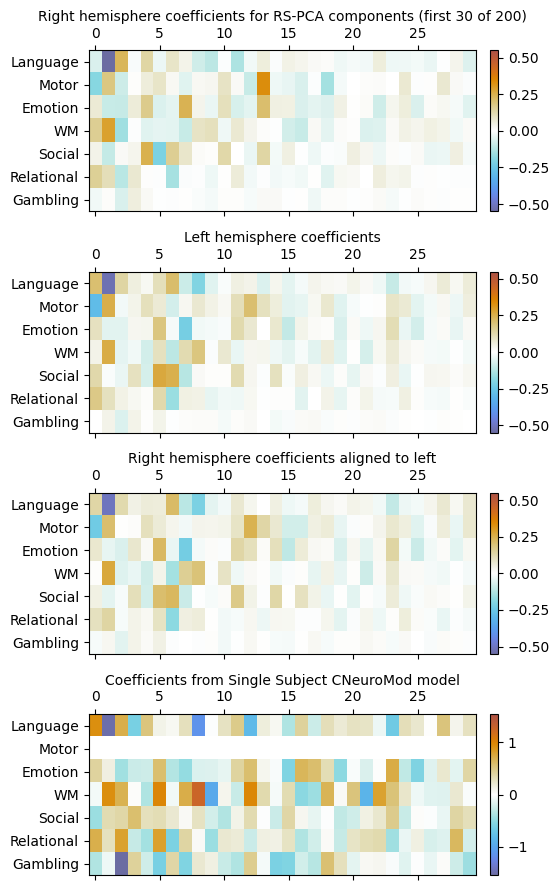

In [106]:
fig, axs = plt.subplots(4,1, figsize=(8,4.5*2)) # 4 plots in a row
data0 = coeffs_R[contrast_ids_to_show,:n_comps]
data1 = coeffs_L[contrast_ids_to_show,:n_comps]
data2 = coeffs_R_aligned2L[contrast_ids_to_show,:n_comps]
# from CneuroMod validation script
dataxx= np.load("cneuro_single_subj_coeffs.npy")
data3 = np.zeros_like(data2)
data3[0,:] = dataxx[0,:]
data3[2:,:] = dataxx[1:,:]

v = np.absolute(np.concatenate((data0, data1,data2))).max()

titles=[f"Right hemisphere coefficients for RS-PCA components (first {n_comps} of 200)", \
        f"Left hemisphere coefficients", "Right hemisphere coefficients aligned to left", "Coefficients from Single Subject CNeuroMod model"];
for i, data in enumerate([data0, data1, data2, data3]):
    if i ==3:
        v = np.absolute(np.concatenate((data3))).max()
    im = axs[i].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
    plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[i])
    axs[i].set_yticks(np.arange(len(task_names))); axs[i].set_yticklabels( task_names);
    axs[i].set_xlabel(titles[i]); axs[i].xaxis.set_label_position('top') 
    plt.tight_layout()